<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/SC%E3%81%8B%E3%82%89CausalImpact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 合成コントロール法とCausal Impactのサンプル

In [48]:
!pip3 install -q  tfcausalimpact

In [2]:
#@title Pythonモジュールをimport { display-mode: "form" }

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from datetime import timedelta

plt.style.use(
    "ggplot"
)  
%matplotlib inline

In [4]:
#@title サンプルデータを取得 { display-mode: "form" }
# 参考
# https://github.com/eXascaleInfolab/2019_kais-bench/blob/7f374df7cdf97c56f20cef07fe51becb08dbec5d/Algorithms/ssa/tslib/tests/testScriptSynthControlALS.py


def fetch_prop99() -> pd.DataFrame:
    """
    タバコ消費データ等を読み込み
    及び加工
    """
    COMMON_COLNAMES = ["Year", "LocationDesc", "Data_Value"]
    SCM_DATA = "https://raw.githubusercontent.com/eXascaleInfolab/2019_kais-bench/7f374df7cdf97c56f20cef07fe51becb08dbec5d/Algorithms/ssa/tslib/tests/testdata/prop99.csv"
    df = pd.read_csv(SCM_DATA)

    _consumption = df.query(
        "SubMeasureDesc == 'Cigarette Consumption (Pack Sales Per Capita)' "
    )[COMMON_COLNAMES].rename(columns={"Data_Value": "consumption"})

    _price = df.query(
        "SubMeasureDesc == 'Federal and State tax as a Percentage of Retail Price ' "
    )[COMMON_COLNAMES].rename(columns={"Data_Value": "retail_price"})

    _df = pd.merge(_consumption, _price, on=["Year", "LocationDesc"])
    _df["is_California"] = _df["LocationDesc"] == "California"
    _df["post_treatment"] = _df["Year"] >= 1989

    return _df.rename(columns={"LocationDesc": "state", "Year": "year"})


scm_df = fetch_prop99()

In [6]:
scm_df = fetch_prop99()
scm_df.tail(15)

,year,state,consumption,retail_price,is_California,post_treatment
2280,1970,Oklahoma,108.4,52.8,False,False
2281,1970,Oregon,157.0,41.4,False,False
2282,1970,Pennsylvania,107.3,58.2,False,False
2283,1970,Rhode Island,123.9,52.2,False,False
2284,1970,South Carolina,103.6,40.8,False,False
2285,1970,South Dakota,92.7,51.9,False,False
2286,1970,Tennessee,99.8,50.5,False,False
2287,1970,Texas,106.4,56.0,False,False
2288,1970,Utah,65.5,43.7,False,False
2289,1970,Vermont,122.6,50.6,False,False


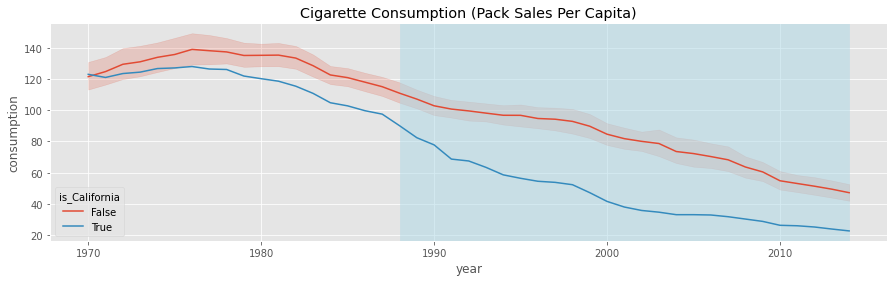

In [7]:
#@title 可視化 { display-mode: "form" }
fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="is_California", data=scm_df, ax=ax)

ax.axvspan(1988, 2014, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## SCM 何をするか整理する(ざっくり)
- 介入前期間 post_treatment == False において、ドナープール（California以外の州 is_California==False）からCaliforniaを説明するモデルを作る
- 上記モデルの予測値を介入期間後post_treatment == Trueに適応
- 上記モデルの出力を反事実とみなして比較する


In [9]:
#@title 軽い前処理 { display-mode: "form" }
scm_df_T = scm_df.pivot(index="state", columns="year")["consumption"].T  # 後で使うから一緒に作っておく

# これでデータを作る
before_treat_df = (
    scm_df.query("~post_treatment").pivot(index="state", columns="year")["consumption"].T
)

y = before_treat_df["California"]

X =  before_treat_df.drop(columns="California")

- 元論文の条件を緩和して、Lasso回帰でSCMを行う

In [10]:
from sklearn.linear_model import LassoCV

lasso_lr = LassoCV(fit_intercept=False).fit(X, y)

weights_lr = lasso_lr.coef_

print("~重み行列~")
selected_states = (
    pd.DataFrame({"coef": weights_lr.round(3)}, index=[X.columns])
    .sort_values("coef", ascending=False)
    .query("coef != 0.")
)
selected_states

~重み行列~


,coef
state,
New Hampshire,0.180
Illinois,0.156
Kentucky,0.115
Nevada,0.114
Massachusetts,0.045
District of Columbia,0.016
Louisiana,0.008


In [13]:
#@title 反事実を生成 { display-mode: "form" }
lasso_result = pd.DataFrame(
    {
        "year": scm_df_T.index,
        "lasso_scm": lasso_lr.predict(scm_df_T.drop(columns="California")),
    }
)

lasso_result = pd.merge(
    lasso_result, scm_df.query("is_California")[["consumption", "year"]], on="year"
).rename(columns={"consumption": "California"})

lasso_result["scm_gap"] =lasso_result.eval("California - lasso_scm")

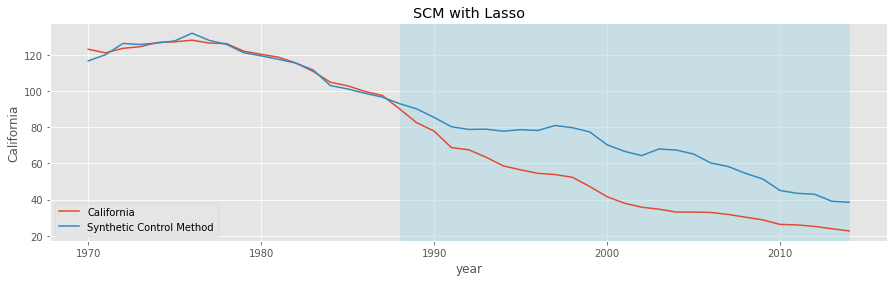

In [14]:
#@title SCMの結果を可視化 (1/2) { display-mode: "form" }
fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="California",data=lasso_result, ax=ax, label="California")
sns.lineplot(x="year", y="lasso_scm",data=lasso_result, ax=ax, label="Synthetic Control Method")

ax.axvspan(1988, 2014, alpha=0.5, color="lightblue")

plt.title("SCM with Lasso")
plt.show()

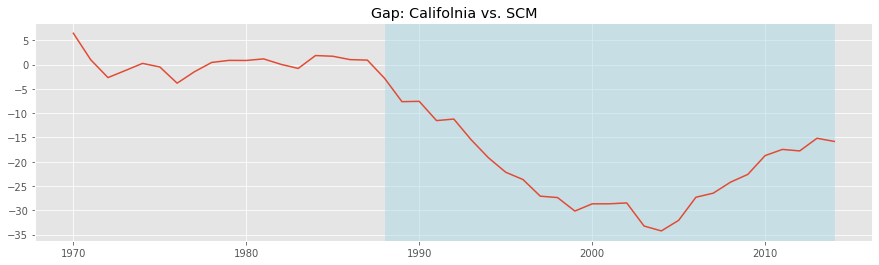

In [15]:
#@title SCMの結果を可視化 (2/2) { display-mode: "form" }
fig, ax = plt.subplots()
fig.set_figwidth(15)

plt.plot(lasso_result["year"], lasso_result["scm_gap"])

ax.axvspan(1988, 2014, alpha=0.5, color="lightblue")

plt.title("Gap: Califolnia vs. SCM")
plt.show()

## Causal Impact
- 提唱論文:
  - Brodersen, K. H., Gallusser, F., Koehler, J., Remy, N., & Scott, S. L. (2015). Inferring causal impact using Bayesian structural time-series models. The Annals of Applied Statistics, 9(1), 247–274. doi: 10.1214/14-AOAS788
-  Python実装上の注意
  - Pythonの推奨パッケージは`tfcausalimpact`

  - バックエンドはTensorFlow Probabilityで実装されている。これが理想

- pycausalimpactの何が問題なの？
  - spike-and-slab事前分布が実装されていない 



In [16]:
import causalimpact

### データ：The Brexit voteにおける為替に対する影響調査
- ギリスEU脱退(Brexit)は為替に影響与えた否か
- DataScriptはほぼ、以下のGoogleBlogからの引用
- [The Brexit vote: A case study in causal inference using machine learning](https://cloud.google.com/blog/topics/developers-practitioners/brexit-vote-case-study-causal-inference-using-machine-learning)
- notebook: [Causal Inference with Vertex AI AutoML Forecasting](https://github.com/kweinmeister/notebooks/blob/master/causal_inference_with_vertex_ai_automl_forecasting.ipynb)

In [39]:
#@title サンプルデータ { display-mode: "form" }
# Training data prior to event
PRE_PERIOD = [pd.to_datetime("2012-01-03"), pd.to_datetime("2016-06-23")]

# Duration of period after the event to analyze
POST_PERIOD_LENGTH = 28
POST_PERIOD = [pd.to_datetime("2016-06-24"), pd.to_datetime("2016-07-22")]

# Lookback window used for forecasting (usually 1-5x the forecast horizon)
CONTEXT_WINDOW = 1 * POST_PERIOD_LENGTH


def read_fred_data(dataset, start_date, end_date):
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={dataset}&cosd={str(start_date)[:10]}&coed={str(end_date)[:10]}"
    return pd.read_csv(url, index_col="DATE", parse_dates=True, na_values=".")

df_DEXUSUK = read_fred_data("DEXUSUK", PRE_PERIOD[0], POST_PERIOD[1])
df_DEXUSEU = read_fred_data("DEXUSEU", PRE_PERIOD[0], POST_PERIOD[1])

# Merge each series into one dataframe
df = (
    pd.merge(
        left=df_DEXUSEU,
        left_on=df_DEXUSEU.index,
        right=df_DEXUSUK,
        right_on=df_DEXUSUK.index,
    )
    .rename(columns={"key_0": "DATE"})
    .set_index("DATE")
    .dropna()
)
df.head()


,DEXUSEU,DEXUSUK
DATE,,
2012-01-03,1.3061,1.5655
2012-01-04,1.2930,1.5638
2012-01-05,1.2783,1.5480
2012-01-06,1.2723,1.5431
2012-01-09,1.2745,1.5436


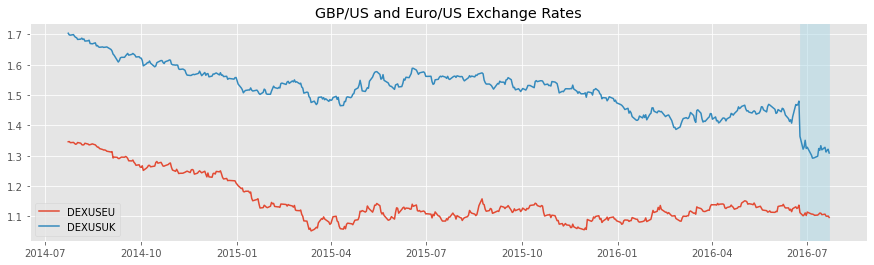

In [41]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
ax.plot(df[POST_PERIOD[1] - timedelta(days=730) : POST_PERIOD[1]])
ax.axvspan(POST_PERIOD[0], POST_PERIOD[1], alpha=0.5, color="lightblue")

plt.title("GBP/US and Euro/US Exchange Rates")
plt.legend(df.columns)
plt.show()

In [43]:
# 時間がないので、ハイパーパラメータは決め打ち
impact_model = causalimpact.CausalImpact(
    df[["DEXUSUK", "DEXUSEU"]], 
    PRE_PERIOD,
    POST_PERIOD, 
)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


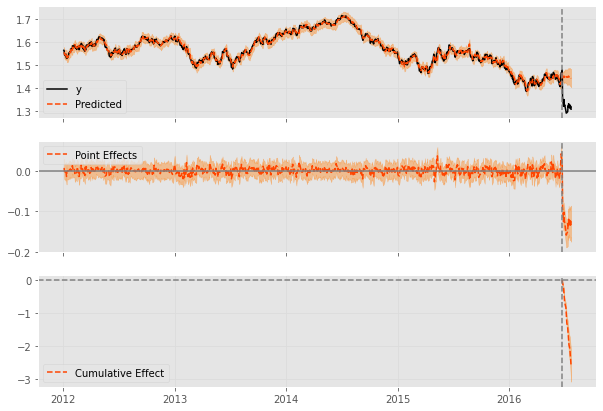

In [44]:
impact_model.plot()

In [45]:
print(impact_model.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1.32               26.38
Prediction (s.d.)         1.45 (0.01)        28.99 (0.25)
95% CI                    [1.43, 1.47]       [28.52, 29.48]

Absolute effect (s.d.)    -0.13 (0.01)       -2.61 (0.25)
95% CI                    [-0.15, -0.11]     [-3.1, -2.13]

Relative effect (s.d.)    -9.0% (0.85%)      -9.0% (0.85%)
95% CI                    [-10.69%, -7.36%]  [-10.69%, -7.36%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
